In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import random

In [2]:
df = pd.read_csv("test_predicted.csv")

loan_data=df[[
    "LoanAmount",
    "InterestRate",
    "LoanTerm","LoanPurpose","DefaultProbability"]]
df.head(10)
loan_data.shape

(109435, 5)

In [3]:
def monthly_payment(P, annual_rate, months):
    r_m = annual_rate / 12
    n=months
    # Amortized loan formula
    M = P * (r_m * (1 + r_m) ** n) / ((1 + r_m) ** n - 1)
    return M


In [4]:
def Future_value(monthly_payments, months):
    return monthly_payments*months

In [5]:
loan_data['MonthlyPayment'] = 0.0
loan_data['FutureValue']=0.0

for i in range(loan_data.shape[0]):
    principal = loan_data.loc[i, "LoanAmount"]
    annual_rate = loan_data.loc[i, "InterestRate"]/100
    months = loan_data.loc[i, "LoanTerm"]
    loan_data.loc[i, "MonthlyPayment"] = monthly_payment(principal, annual_rate, months)
    loan_data.loc[i,'FutureValue']= Future_value(loan_data.loc[i, "MonthlyPayment"], months)
loan_data.head(10)

C:\Users\thanh\AppData\Local\Temp\ipykernel_34208\1536764622.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data['MonthlyPayment'] = 0.0
C:\Users\thanh\AppData\Local\Temp\ipykernel_34208\1536764622.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data['FutureValue']=0.0


,LoanAmount,InterestRate,LoanTerm,LoanPurpose,DefaultProbability,MonthlyPayment,FutureValue
0,43797,6.10,24,Other,0.169157,1943.083842,46634.012209
1,18402,12.99,60,Business,0.067436,418.607855,25116.471272
2,151774,5.51,48,Other,0.073382,3530.420002,169460.160086
3,55789,23.93,36,Business,0.433869,2186.711676,78721.620332
4,189798,22.05,48,Auto,0.252992,5984.943769,287277.300894
5,196031,19.75,60,Education,0.164508,5166.391522,309983.491309
6,32179,6.45,24,Education,0.088060,1432.726740,34385.441754
7,101882,12.82,12,Business,0.145396,9091.221020,109094.652237
8,11560,22.84,36,Other,0.213354,446.520936,16074.753686
9,172152,13.28,12,Other,0.206757,15398.771735,184785.260817


In [6]:
loan_data['Loan_end_boolean'] = np.zeros(loan_data.shape[0], dtype=bool)
loan_data.head(10)

C:\Users\thanh\AppData\Local\Temp\ipykernel_34208\544357364.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data['Loan_end_boolean'] = np.zeros(loan_data.shape[0], dtype=bool)


,LoanAmount,InterestRate,LoanTerm,LoanPurpose,DefaultProbability,MonthlyPayment,FutureValue,Loan_end_boolean
0,43797,6.10,24,Other,0.169157,1943.083842,46634.012209,False
1,18402,12.99,60,Business,0.067436,418.607855,25116.471272,False
2,151774,5.51,48,Other,0.073382,3530.420002,169460.160086,False
3,55789,23.93,36,Business,0.433869,2186.711676,78721.620332,False
4,189798,22.05,48,Auto,0.252992,5984.943769,287277.300894,False
5,196031,19.75,60,Education,0.164508,5166.391522,309983.491309,False
6,32179,6.45,24,Education,0.088060,1432.726740,34385.441754,False
7,101882,12.82,12,Business,0.145396,9091.221020,109094.652237,False
8,11560,22.84,36,Other,0.213354,446.520936,16074.753686,False
9,172152,13.28,12,Other,0.206757,15398.771735,184785.260817,False


In [7]:
loan_data=loan_data[["LoanTerm","LoanPurpose","MonthlyPayment","FutureValue", "Loan_end_boolean"]]
loan_data["PD0"]=df["DefaultProbability"]
loan_test = pd.DataFrame({
    "LoanTerm": [24, 36, 60, 24],
    "LoanPurpose": ["Business", "Personal", "Business", "Education"],
    "MonthlyPayment": [2000, 500, 1500, 800],
    "FutureValue": [80000, 25000, 50000, 30000],
    "PD0": [0.15, 0.08, 0.10, 0.25],
    "Loan_end_boolean": False
})


In [8]:
#Simulation setup

In [9]:
def calculate_pd_matrix(loan_data, rate, max_term):
    """Vectorized PD calculation using your specified formula"""
    is_business = (loan_data["LoanPurpose"] == "Business").values
    pd0 = loan_data["PD0"].values
    loan_terms = loan_data["LoanTerm"].values
    
    # Create time grid [max_term x n_loans]
    t = np.arange(max_term)[:, np.newaxis]
    active_mask = t < loan_terms  # [max_term x n_loans]
    
    # Initialize PD matrix
    pd_matrix = np.zeros((max_term, len(loan_data)))
    
    # Business loans: PD grows to 1
    business_mask = active_mask & is_business
    exponent_biz = -rate * t
    pd_matrix[business_mask] = 1 / (1 + (1/pd0 - 1) * np.exp(exponent_biz))[business_mask]
    
    # Non-business loans: PD decays to 0
    non_biz_mask = active_mask & ~is_business
    exponent_non_biz = rate * t
    pd_matrix[non_biz_mask] = 1 / (1 + (1/pd0 - 1) * np.exp(exponent_non_biz))[non_biz_mask]
    
    return pd_matrix

In [30]:
def simulate_cashflows(data, rate=0.1, recovery_rate=0.2, 
                      default_events=None, rng=None):
    loan_data=data.copy()
    if rng is None:
        rng = np.random.default_rng()
    
    max_term = loan_data["LoanTerm"].max()
    cashflow_matrix = np.zeros((max_term, len(loan_data)))
    loan_ended = loan_data["Loan_end_boolean"].values.copy()
    pd_matrix = calculate_pd_matrix(loan_data, rate, max_term)
    
    # Convert default_events to dictionary for quick lookup
    event_dict = dict(default_events) if default_events else {}

    for t in range(max_term):
        active_mask = (~loan_ended) & (t <= loan_data["LoanTerm"].values)
        active_idx = np.where(active_mask)[0]
        current_pd = pd_matrix[t, active_idx]
        sum_pd = current_pd.sum()
        # Get default count for this t (0 if not specified)
        n_defaults = event_dict.get(t, 0)
        n_defaults = min(n_defaults, len(active_idx))  # Can't exceed active loans
        
        if n_defaults > 0 and sum_pd > 1e-8:
            # PD-weighted selection
            weights = current_pd / sum_pd
            weights /= weights.sum()  # Ensure exact sum=1
            chosen = rng.choice(active_idx, size=int(n_defaults), replace=False, p=weights)
            # Calculate recovery
            fv = loan_data["FutureValue"].values[chosen]
            pmt = loan_data["MonthlyPayment"].values[chosen]
            cashflow_matrix[t, chosen] = (fv - (t)*pmt) * recovery_rate
            loan_ended[chosen] = True
            # Regular payments for non-defaults
            non_default = np.setdiff1d(active_idx, chosen)
            cashflow_matrix[t, non_default] = loan_data["MonthlyPayment"].values[non_default]
        else:
            cashflow_matrix[t, active_idx] = loan_data["MonthlyPayment"].values[active_idx]
    loan_data["Loan_end_boolean"] = loan_ended
    return cashflow_matrix,pd_matrix

In [31]:
def default_schedule_generation(loan_data,num_default_times, total_percent, 
                               peak_center=24, peak_std=12, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    max_term = loan_data["LoanTerm"].max()
    # Generate default times with normal distribution
    times = []
    while len(times) < num_default_times:
        new_times = rng.normal(loc=peak_center, scale=peak_std, 
                             size=num_default_times - len(times))
        new_times = np.clip(np.round(new_times), 1, max_term).astype(int)
        times = list(np.unique(np.concatenate([times, new_times])))
    
    # Assign percentages using Dirichlet distribution
    proportions = rng.dirichlet(np.ones(num_default_times))
    percentages = proportions * total_percent
    people_default_num=(percentages/100)*loan_data.shape[0]
    for i in range(len(people_default_num)):
        people_default_num[i]=int(people_default_num[i])-1
    return sorted(zip(times, people_default_num), key=lambda x: x[0])


In [65]:
# Run simulation
#no defaults, ideal case
results_no_defaults,pd_matrix = simulate_cashflows(
    loan_data,
    rate=0.15,
    recovery_rate=0.3,
)
no_default_data=np.sum(results_no_defaults, axis=1)
no_default_data

array([6.14964813e+08, 6.14964813e+08, 6.14964813e+08, 6.14964813e+08,
       6.14964813e+08, 6.14964813e+08, 6.14964813e+08, 6.14964813e+08,
       6.14964813e+08, 6.14964813e+08, 6.14964813e+08, 6.14964813e+08,
       6.14964813e+08, 3.70188373e+08, 3.70188373e+08, 3.70188373e+08,
       3.70188373e+08, 3.70188373e+08, 3.70188373e+08, 3.70188373e+08,
       3.70188373e+08, 3.70188373e+08, 3.70188373e+08, 3.70188373e+08,
       3.70188373e+08, 2.37288084e+08, 2.37288084e+08, 2.37288084e+08,
       2.37288084e+08, 2.37288084e+08, 2.37288084e+08, 2.37288084e+08,
       2.37288084e+08, 2.37288084e+08, 2.37288084e+08, 2.37288084e+08,
       2.37288084e+08, 1.42064604e+08, 1.42064604e+08, 1.42064604e+08,
       1.42064604e+08, 1.42064604e+08, 1.42064604e+08, 1.42064604e+08,
       1.42064604e+08, 1.42064604e+08, 1.42064604e+08, 1.42064604e+08,
       1.42064604e+08, 6.47439072e+07, 6.47439072e+07, 6.47439072e+07,
       6.47439072e+07, 6.47439072e+07, 6.47439072e+07, 6.47439072e+07,
      

In [66]:
# 3% of portfolio defaults at random number of time
default_schedule_rand_3=default_schedule_generation(loan_data,random.randint(1,int(100/3)),3)
results_3,pd_matrix = simulate_cashflows(
    loan_data,
    rate=0.15,
    recovery_rate=0.3,
    default_events=default_schedule_rand_3
)
print(default_schedule_rand_3)
data_3=np.sum(results_3, axis=1)
print(data_3)

[(1.0, 80.0), (2.0, 23.0), (9.0, 154.0), (11.0, 381.0), (12.0, 124.0), (13.0, 142.0), (14.0, 175.0), (15.0, 199.0), (16.0, 112.0), (18.0, 60.0), (20.0, 72.0), (21.0, 157.0), (22.0, 232.0), (23.0, 52.0), (25.0, 66.0), (26.0, 14.0), (27.0, 27.0), (28.0, 36.0), (29.0, 57.0), (31.0, 40.0), (32.0, 9.0), (33.0, 71.0), (34.0, 197.0), (36.0, 117.0), (37.0, 74.0), (38.0, 50.0), (39.0, 291.0), (42.0, 24.0), (44.0, 187.0), (50.0, 16.0)]
[6.14964813e+08 6.18270658e+08 6.15411757e+08 6.14310256e+08
 6.14310256e+08 6.14310256e+08 6.14310256e+08 6.14310256e+08
 6.14310256e+08 6.18925414e+08 6.13334434e+08 6.22980288e+08
 6.15486795e+08 3.71838505e+08 3.71503406e+08 3.71229553e+08
 3.67417332e+08 3.64351497e+08 3.65773289e+08 3.64082261e+08
 3.65294788e+08 3.66230250e+08 3.67068252e+08 3.62910960e+08
 3.61841257e+08 2.33417593e+08 2.31928569e+08 2.32022542e+08
 2.32154401e+08 2.32256547e+08 2.31215515e+08 2.31789782e+08
 2.31223755e+08 2.31754327e+08 2.32773020e+08 2.30067838e+08
 2.31534652e+08 1.383

In [67]:
# 10% of portfolio defaults at random number of time
default_schedule_rand_10=default_schedule_generation(loan_data,random.randint(1,int(100/10)),10)
results_10,pd_matrix = simulate_cashflows(
    loan_data,
    rate=0.15,
    recovery_rate=0.3,
    default_events=default_schedule_rand_10
)
data_10=np.sum(results_10, axis=1)
print(default_schedule_rand_10)
print(data_10)

[(17.0, 9990.0), (22.0, 950.0)]
[6.14964813e+08 6.14964813e+08 6.14964813e+08 6.14964813e+08
 6.14964813e+08 6.14964813e+08 6.14964813e+08 6.14964813e+08
 6.14964813e+08 6.14964813e+08 6.14964813e+08 6.14964813e+08
 6.14964813e+08 3.70188373e+08 3.70188373e+08 3.70188373e+08
 3.70188373e+08 6.12364907e+08 3.25635728e+08 3.25635728e+08
 3.25635728e+08 3.25635728e+08 3.41656042e+08 3.21459361e+08
 3.21459361e+08 2.06185982e+08 2.06185982e+08 2.06185982e+08
 2.06185982e+08 2.06185982e+08 2.06185982e+08 2.06185982e+08
 2.06185982e+08 2.06185982e+08 2.06185982e+08 2.06185982e+08
 2.06185982e+08 1.23144632e+08 1.23144632e+08 1.23144632e+08
 1.23144632e+08 1.23144632e+08 1.23144632e+08 1.23144632e+08
 1.23144632e+08 1.23144632e+08 1.23144632e+08 1.23144632e+08
 1.23144632e+08 5.61939022e+07 5.61939022e+07 5.61939022e+07
 5.61939022e+07 5.61939022e+07 5.61939022e+07 5.61939022e+07
 5.61939022e+07 5.61939022e+07 5.61939022e+07 5.61939022e+07]


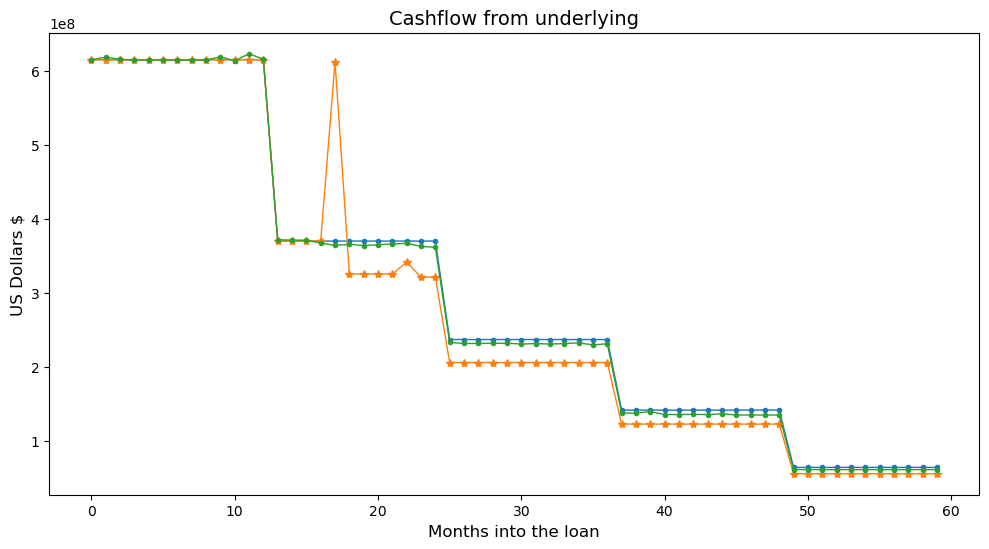

In [68]:
plt.figure(figsize=(12, 6))
plt.plot(no_default_data, marker='.', linestyle='-', linewidth=1)
plt.plot(data_10, marker='*', linestyle='-', linewidth=1)
plt.plot(data_3, marker='.', linestyle='-', linewidth=1)
plt.xlabel('Months into the loan', fontsize=12)
plt.ylabel('US Dollars $', fontsize=12)
plt.title('Cashflow from underlying', fontsize=14)
plt.show()

In [69]:
df.shape

(109435, 19)

In [70]:
cdo_data= pd.read_csv("clustered_output.csv")


In [71]:
cdo_data=cdo_data[["LoanAmount",
    "LoanTerm", "Cluster"]]
cdo_data

,LoanAmount,LoanTerm,Cluster
0,43797,24,0
1,18402,60,1
2,151774,48,0
3,55789,36,2
4,189798,48,2
...,...,...,...
109430,108110,36,0
109431,238508,24,0
109432,18513,36,1
109433,38414,36,2


In [72]:
cdo_data["Principal"]=cdo_data["LoanAmount"]/cdo_data["LoanTerm"]
cdo_data["Principal"]

0         1824.875000
1          306.700000
2         3161.958333
3         1549.694444
4         3954.125000
             ...     
109430    3003.055556
109431    9937.833333
109432     514.250000
109433    1067.055556
109434    4638.729167
Name: Principal, Length: 109435, dtype: float64

In [73]:
Tranches_size = []
for i in range(0, 3):
    tranche_sum = cdo_data["LoanAmount"][cdo_data["Cluster"] == i].sum()
    Tranches_size.append(tranche_sum)
    
Tranches_size

[4421153849, 5256249631, 4274085879]

In [74]:
Principal_senior = []
Principal_mez = []
Interest_senior = []
Interest_mez = []

for i in range(0, cdo_data["LoanTerm"].max()):
    # Get boolean Series from time_mask
    time_condition = cdo_data["LoanTerm"] >= i
    
    # Create combined masks
    senior_mask = time_condition & (cdo_data["Cluster"] == 1)
    mez_mask = time_condition & (cdo_data["Cluster"] == 0)
    
    # Calculate principal payments
    Principal_senior.append(cdo_data["Principal"][senior_mask].sum())
    Principal_mez.append(cdo_data["Principal"][mez_mask].sum())
    Interest_senior.append(cdo_data["LoanAmount"][senior_mask].sum() * (0.05/12))
    Interest_mez.append(cdo_data["LoanAmount"][mez_mask].sum() * (0.07/12))  

In [75]:
print(Principal_senior[0])
print(Principal_mez[0])
print(Interest_senior[0])
print(Interest_mez[0])

198874562.12222221
166621793.4013889
21901040.129166666
25790064.11916667


In [76]:
print(Principal_senior[0]+Principal_mez[0]+Interest_senior[0]+Interest_mez[0])

413187459.77194446


In [77]:
residual= []
for i in range(0,60):
    residual.append(no_default_data[i]-(Principal_senior[i]+Principal_mez[i]+Interest_senior[i]+Interest_mez[i]))

In [78]:
residual

[201777353.4497884,
 201777353.4497884,
 201777353.4497884,
 201777353.4497884,
 201777353.4497884,
 201777353.4497884,
 201777353.4497884,
 201777353.4497884,
 201777353.4497884,
 201777353.4497884,
 201777353.4497884,
 201777353.4497884,
 201777353.4497884,
 124159165.88179436,
 124159165.88179436,
 124159165.88179436,
 124159165.88179436,
 124159165.88179436,
 124159165.88179436,
 124159165.88179436,
 124159165.88179436,
 124159165.88179436,
 124159165.88179436,
 124159165.88179436,
 124159165.88179436,
 81332067.27274767,
 81332067.27274767,
 81332067.27274767,
 81332067.27274767,
 81332067.27274767,
 81332067.27274767,
 81332067.27274767,
 81332067.27274767,
 81332067.27274767,
 81332067.27274767,
 81332067.27274767,
 81332067.27274767,
 49144983.41679418,
 49144983.41679418,
 49144983.41679418,
 49144983.41679418,
 49144983.41679418,
 49144983.41679418,
 49144983.41679418,
 49144983.41679418,
 49144983.41679418,
 49144983.41679418,
 49144983.41679418,
 49144983.41679418,
 2249989

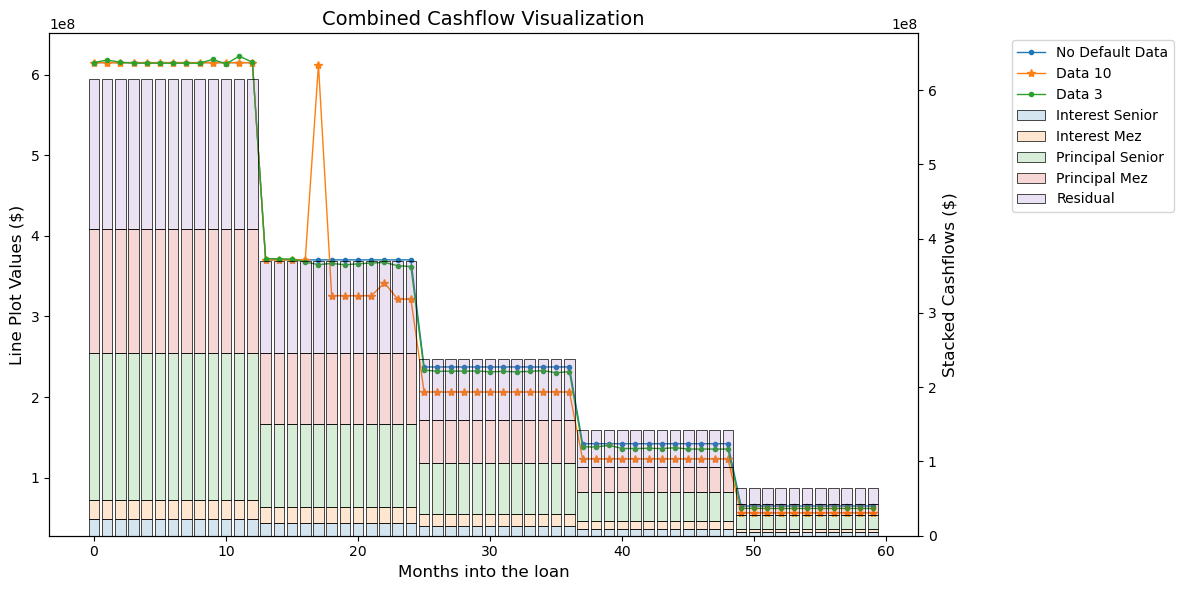

In [79]:

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot lines on primary axis
ax1.plot(no_default_data, marker='.', linestyle='-', linewidth=1, label='No Default Data')
ax1.plot(data_10, marker='*', linestyle='-', linewidth=1, label='Data 10')
ax1.plot(data_3, marker='.', linestyle='-', linewidth=1, label='Data 3')
ax1.set_xlabel('Months into the loan', fontsize=12)
ax1.set_ylabel('Line Plot Values ($)', fontsize=12)
ax2 = ax1.twinx()
width = 0.8
indices = np.arange(len(Principal_senior))
# Stack components bottom-to-top
components = [
    Interest_senior,
    Interest_mez,
    Principal_senior,
    Principal_mez,
    residual
]

colors = ['#1f77b430', '#ff7f0e30', '#2ca02c30', '#d6272830', '#9467bd30']
labels = [ 
         'Interest Senior', 'Interest Mez','Principal Senior', 'Principal Mez',"Residual"]

bottom = np.zeros(len(Principal_senior))
for i, (comp, color) in enumerate(zip(components, colors)):
    ax2.bar(indices, comp, width, bottom=bottom, 
           color=color, edgecolor='black', linewidth=0.5,
           label=labels[i])
    bottom += comp

ax2.set_ylabel('Stacked Cashflows ($)', fontsize=12)
ax2.set_ylim(0, max(bottom)*1.1)  # Add 10% headroom


lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, 
          bbox_to_anchor=(1.1, 1), loc='upper left')

plt.title('Combined Cashflow Visualization', fontsize=14)
plt.tight_layout()

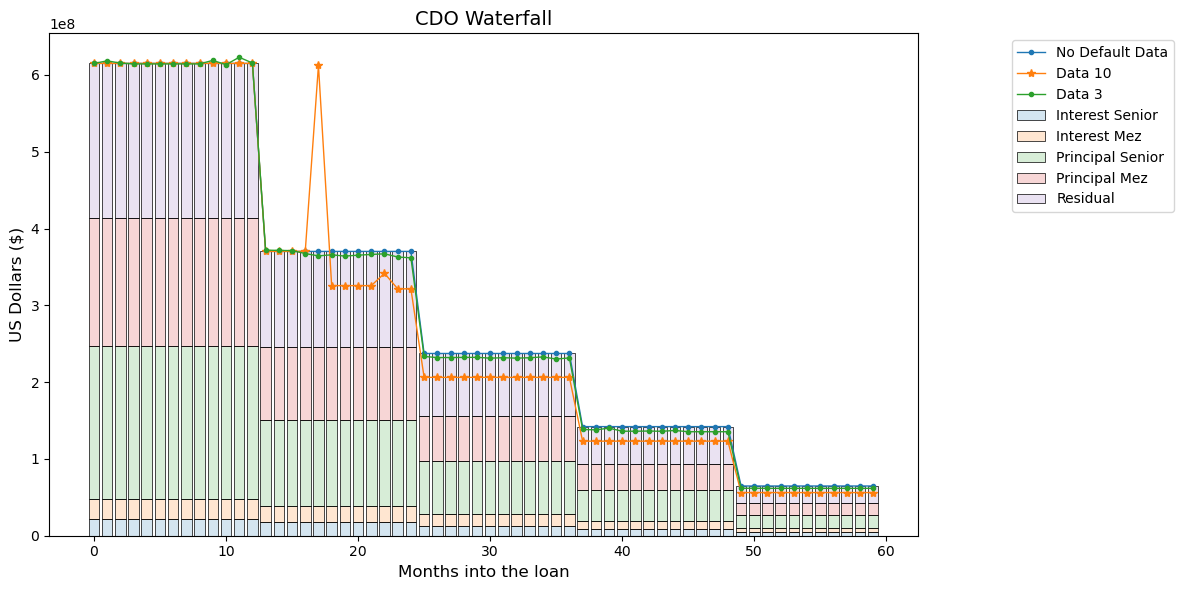

In [80]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot lines
ax1.plot(no_default_data, marker='.', linestyle='-', linewidth=1, label='No Default Data')
ax1.plot(data_10, marker='*', linestyle='-', linewidth=1, label='Data 10')
ax1.plot(data_3, marker='.', linestyle='-', linewidth=1, label='Data 3')
ax1.set_xlabel('Months into the loan', fontsize=12)
ax1.set_ylabel('US Dollars ($)', fontsize=12) 

# Plot stacked bars on the same axis
width = 0.8
indices = np.arange(len(Principal_senior))
components = [
    Interest_senior,
    Interest_mez,
    Principal_senior,
    Principal_mez,
    residual
]
colors = ['#1f77b430', '#ff7f0e30', '#2ca02c30', '#d6272830', '#9467bd30']
labels = ['Interest Senior', 'Interest Mez', 'Principal Senior', 'Principal Mez', 'Residual']

bottom = np.zeros(len(Principal_senior))
for i, (comp, color) in enumerate(zip(components, colors)):
    ax1.bar(indices, comp, width, bottom=bottom, 
            color=color, edgecolor='black', linewidth=0.5,
            label=labels[i])
    bottom += comp


# Combine legends
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, bbox_to_anchor=(1.1, 1), loc='upper left')

plt.title('CDO Waterfall', fontsize=14)
plt.tight_layout()
plt.savefig("CDO Waterfall", dpi=300)
plt.show()